# Diffusion

## Forward Diffusion Process:

$$x_{t} = \sqrt{1 - \beta_t} x_{t-1} + \sqrt{\beta_t} \epsilon \qquad \epsilon \sim N(0, I)$$

Variance preserving

$$x_{t-1} \sim N(0, I) \implies \text{Var}[x_t] = (1 - \beta_t) + \beta_t = 1$$

Sampling $x_t$ in a single step:

$$\text{Let } \alpha_t = 1 - \beta_t, \qquad \bar \alpha_t = \prod_{t=1}^T \alpha_t$$

$$
\begin{align*}

x_t &= \sqrt{1 - \beta_t} x_{t-1} + \sqrt{\beta_t} \epsilon \\

&= \sqrt{1 - \beta_t} \left[ \sqrt{1 - \beta_{t-1}} x_{t-2} + \sqrt{\beta_{t-1}} \epsilon \right] + \sqrt{\beta_t} \epsilon \\

&= \sqrt{1 - \beta_t} \sqrt{1 - \beta_{t-1}} x_{t-2} + \sqrt{1 - \beta_t} \sqrt{\beta_{t-1}} \epsilon + \sqrt{\beta_t} \epsilon \\

&= \sqrt{\alpha_t \alpha_{t-1}} x_{t-2} + \sqrt{1 - \alpha_t \alpha_{t-1}} \epsilon \\

x_t &= \sqrt{\bar \alpha_t} x_0 + \sqrt{1 - \bar \alpha_t} \epsilon \\
\end{align*}
$$

## Reverse Diffusion Process:

Train a neural network that models:

$$p_\theta(x_{t-1} | x_t) = N(\mu_\theta(x_t, t), \Sigma_\theta(x_t, t))$$

$$\mu_\theta(x_t, t) = \frac{1}{\sqrt{\alpha_t}} \left( x_t - \frac{1 - \alpha_t}{\sqrt{1 - \bar \alpha_t}} \epsilon_\theta(x_t, t) \right)$$

$$\Sigma_\theta(x_t, t) = \frac{1 - \bar \alpha_{t-1}}{1 - \bar \alpha_t} \beta_t$$

Loss:

$$
\begin{align*}

L &= \mathbb{E} \left[ \frac{(1-\alpha_t)^2}{2 \alpha_t (1 - \bar \alpha_t) ||\Sigma_\theta||^2}
||\epsilon - \epsilon_\theta(\sqrt{\bar \alpha_t} x_0 + \sqrt{1 - \bar \alpha_t} \epsilon, t)||^2 \right] \\ \\

L_\text{simple} &= \mathbb{E} \left[ ||\epsilon - \epsilon_\theta(\sqrt{\bar \alpha_t} x_0 + \sqrt{1 - \bar \alpha_t} \epsilon, t)||^2 \right]

\end{align*}
$$

Sampling:

$$
\begin{align*}
& x_T \sim N(0, I) \\

& \text{for t in T..1}: \\
& \qquad \epsilon \sim N(0, I) \ \text{ if } t > 1 \ \text{ else } 0 \\
& \qquad x_{t-1} = \frac{1}{\sqrt{\alpha_t}} \left(x_t - \frac{1 - \alpha_t}{\sqrt{1 - \bar \alpha_t}} \epsilon_\theta(x_t, t) \right) + \sigma_t \epsilon \\ \\

\sigma_t^2 &= \frac{1 - \bar \alpha_{t-1}}{1 - \bar \alpha_t} \beta_t \qquad \text{or} \qquad \beta_t

\end{align*}
$$

Alternate interpretation of diffusion from Langevin Dynamics: diffusion models learn $\nabla_x \log p(x)$, the way the image should be perturbed (denoised) to make it match the data distribution.

What does the reweighted objective $L_\text{simple}$ change? First we must schedule $\beta_t$

## $\beta_t$ schedule

Desmos plots: https://www.desmos.com/calculator/74swzuyya5

$$\alpha_t = \text{max}(\frac{\bar \alpha_t}{\bar \alpha_{t-1}}, 0.001) \qquad \beta_t = 1 - \alpha_t$$

$$\bar \alpha_t = \frac{f(t)}{f(0)} \qquad f(t) = \cos^2 \left( \frac{t / T + s}{1 + s} \cdot \frac{\pi}{2} \right)$$

This noise schedule strongly prioritizes the low noise regime, very gradually increasing noise for a long time, and only adding a lot of noise only for $t$ very close to the $T$. This schedule makes the model spend less time denoising extremely noisy images, which doesn't matter as much as denoising coherent images.

So back to the important question: What does the reweighted objective $L_\text{simple}$ change?

The scaling term dropped by the reweighted objective is

$$\frac{(1-\alpha_t)^2}{2 \alpha_t (1 - \bar \alpha_t) ||\Sigma_\theta||^2}$$

This term is very very small until it blows up when $t$ gets close to $T$. By removing this weighting term, we are again decreasing the importance the model gives to denoising extremely noisy images and focusing the model on more meaningful denoising steps.

/home/gordo/code/bml/.venv/lib/python3.10/site-packages/torch/__init__.py:1617: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  _C._set_float32_matmul_precision(precision)


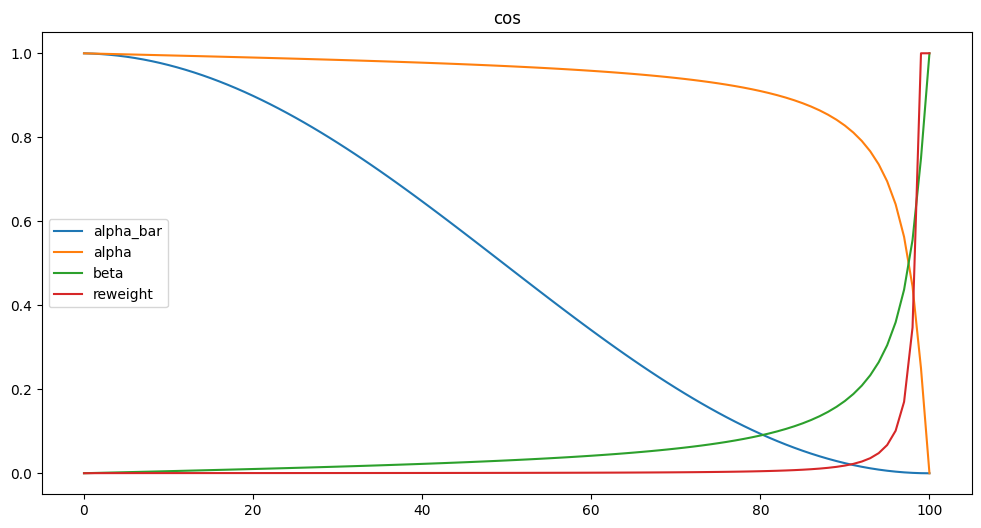

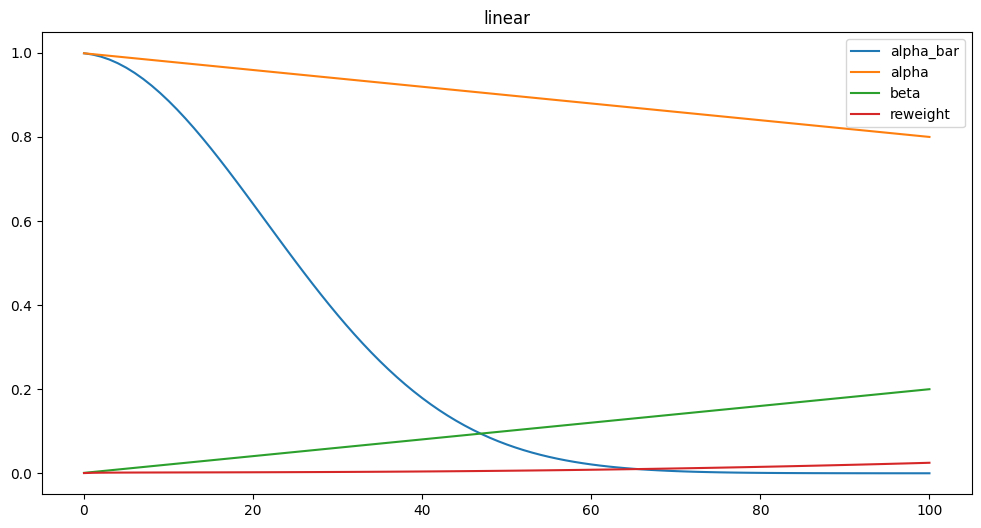

In [1]:
import torch
import matplotlib.pyplot as plt
import ddpm

def plot_noise_schedule(noise_schedule: ddpm.NoiseSchedule, name: str):
    _, ax = plt.subplots(figsize=(12, 6))
    t = torch.arange(noise_schedule.max_time + 1)

    ax.plot(t, noise_schedule.alpha_bar, label="alpha_bar")
    ax.plot(t, noise_schedule.alpha, label="alpha")
    ax.plot(t, noise_schedule.beta, label="beta")

    reweight = ((1 - noise_schedule.alpha) ** 2) / (2 * noise_schedule.alpha * (1 - noise_schedule.alpha_bar))
    ax.plot(t, reweight.clip(0, 1), label="reweight")

    ax.set_title(name)
    ax.legend()
    plt.show()

for (name, noise_schedule) in ddpm.NOISE_SCHEDULES.items():
    plot_noise_schedule(noise_schedule(max_time=100), name)

torch.Size([100, 1, 28, 28]) tensor(-1.) tensor(1.)


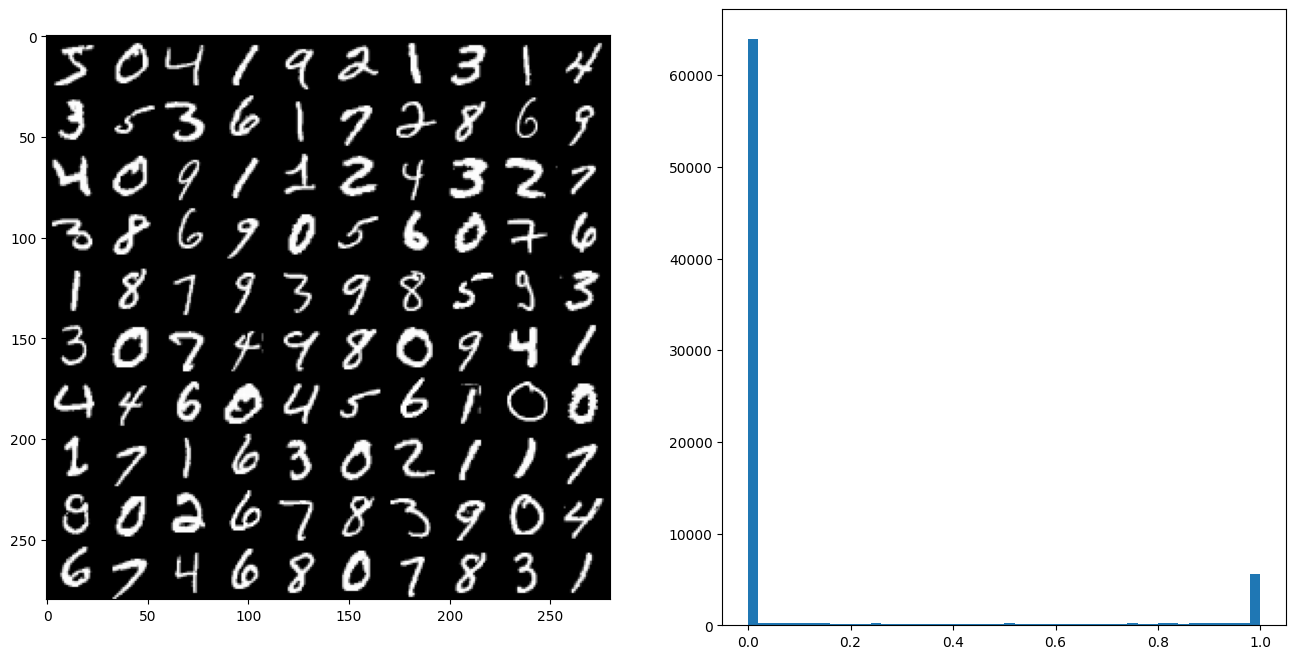

torch.Size([100, 3, 64, 64]) tensor(-1.) tensor(1.)


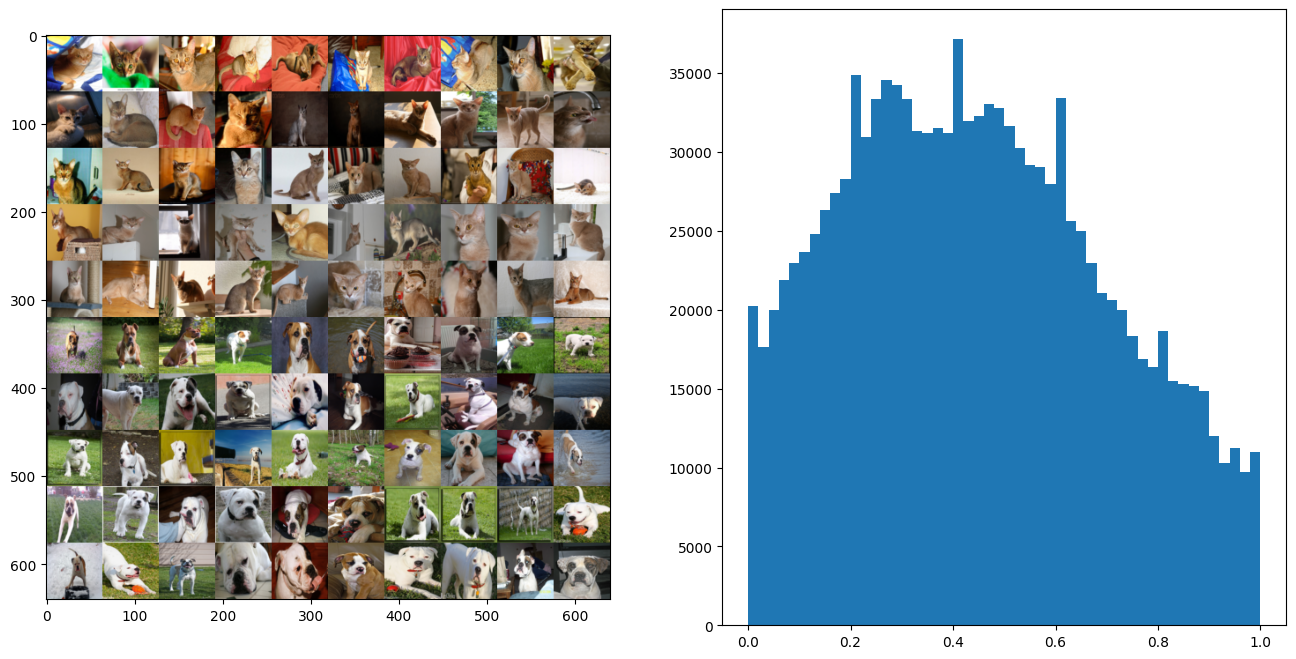

In [2]:
from torch.utils.data import Dataset
from einops import rearrange

def to_images(x: torch.Tensor) -> torch.Tensor:
    x = rearrange(x, "b c h w -> b h w c")
    return (x + 1) / 2

def plot_dataset(dataset: Dataset):
    images = torch.stack([dataset[i] for i in range(100)], dim=0)
    print(images.shape, images.min(), images.max())

    _, (img_ax, hist_ax) = plt.subplots(ncols=2, figsize=(16, 8))
    images = rearrange(to_images(images), "(row col) h w c -> (row h) (col w) c", row=10, col=10)
    img_ax.imshow(images, cmap="grey")
    hist_ax.hist(images.flatten(), bins=50)
    plt.show()

mnist = ddpm.get_dataset("mnist", image_size=28)
plot_dataset(mnist)

pets = ddpm.get_dataset("pets", image_size=64)
plot_dataset(pets)

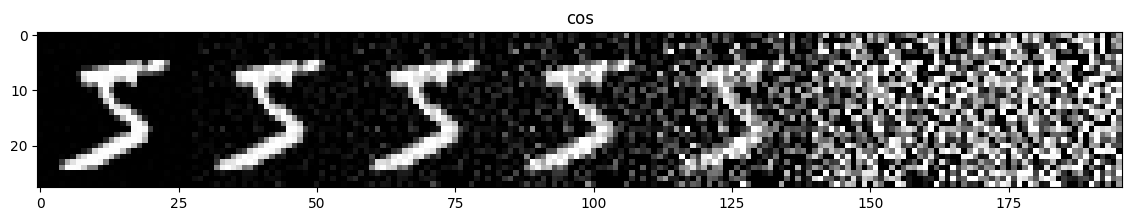

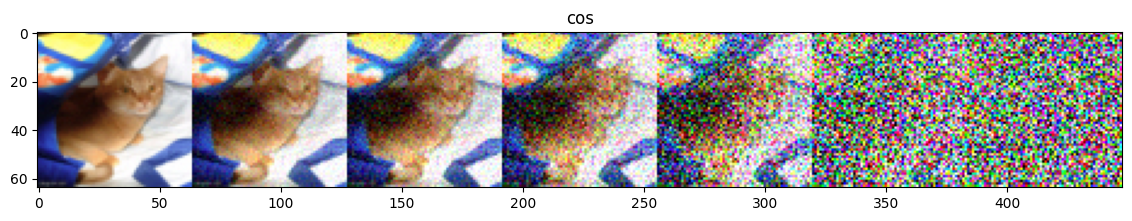

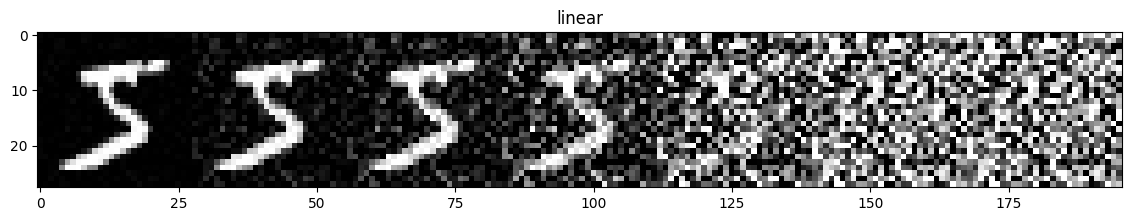

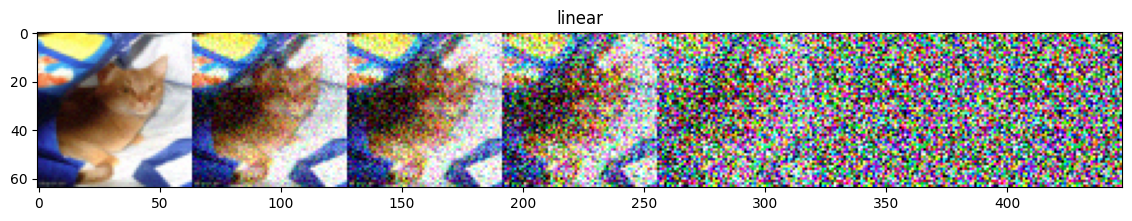

In [3]:
for (name, noise_schedule_class) in ddpm.NOISE_SCHEDULES.items():
    for dataset in (mnist, pets):
        noise_schedule = noise_schedule_class(max_time=100)
        _, noised = noise_schedule.add_noise(dataset[0].unsqueeze(0), torch.tensor([0, 5, 10, 20, 40, 80, 100]))
        noised.clip_(-1, 1)
        noised = to_images(noised)

        fig, ax = plt.subplots(figsize=(14, 4))
        ax.imshow(rearrange(noised, "b h w c -> h (b w) c"), cmap="grey")
        ax.set_title(name)
        plt.show()

## Model
* Unet: unmasked PixelCNN++
* self atten at 16x16 feature map
* cifar10 35.7M params

### Transfomer Positional Embedding

$$\text{PE}(\text{pos}, 2i) = \sin(\frac{\text{pos}}{10000^{2i/d_{\text{model}}}})$$

$$\text{PE}(\text{pos}, 2i + 1) = \cos(\frac{\text{pos}}{10000^{2i/d_{\text{model}}}})$$

$$i = 1 \dots \frac{d_{\text{model}}}{2} - 1$$

These are alternating sines and cosines (alternating in the emb dimension) over the position.

The sin/cos frequency is:

$$
\begin{align*}

\text{freq} &= \frac{1}{2 \pi} \cdot \frac{1}{10000^{2i / d_\text{model}}} \\ \\

i = 0: \qquad \text{freq} &= \frac{1}{2 \pi} \\

i = \frac{d_\text{model}}{2}: \qquad \text{freq} &= \frac{1}{2 \pi \cdot 10000}

\end{align*}
$$

Increasing the embedding dimension decreases the frequency of the sin/cos wave.

$\text{PE}(\text{pos} + k)$ is a linear comb of $\text{PE}(\text{pos})$ since:

$$
\begin{align*}

\sin(p + k) = \sin(p) \cos(k) + \cos(p) \sin(k) \\

\cos(p + k) = \cos(p) \cos(k) - \sin(p) \sin(k) \\

\end{align*}
$$

The longest period is

$$i = \frac{d_\text{model}}{2}: \qquad \text{period} = 2 \pi \cdot 10000 \approx 60,000$$

Assuming a max of $\sim 1000$ diffusion steps, this period is waaay too high. The sin/cos of the last embedding dim will barely move at the max diffusion steps, which is very wasteful because that makes it basically a constant.

If we have max of $T$ steps, and we want the last sin/cos to go fraction $C$ of a cycle, then $\frac{T}{C}$ is the maximum period we need, so we have

$$\sin(\frac{2 \pi \cdot p}{\frac{T}{C}})$$

$$10000 \implies \frac{1}{2 \pi} \cdot \frac{T}{C}$$

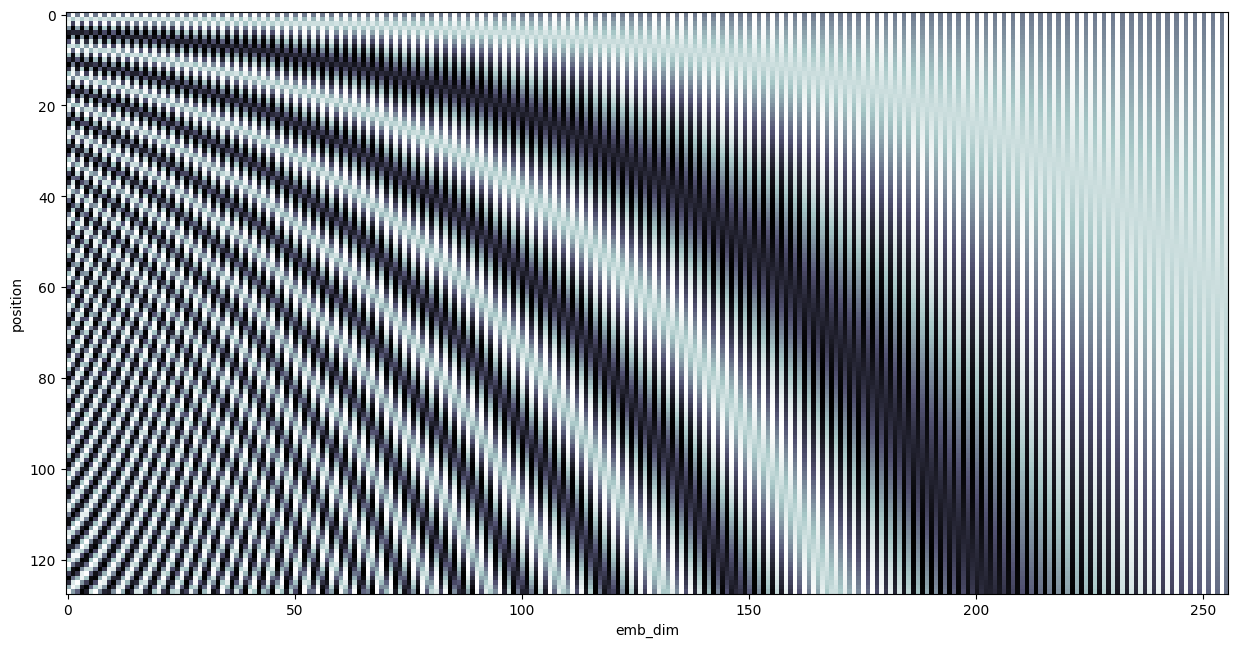

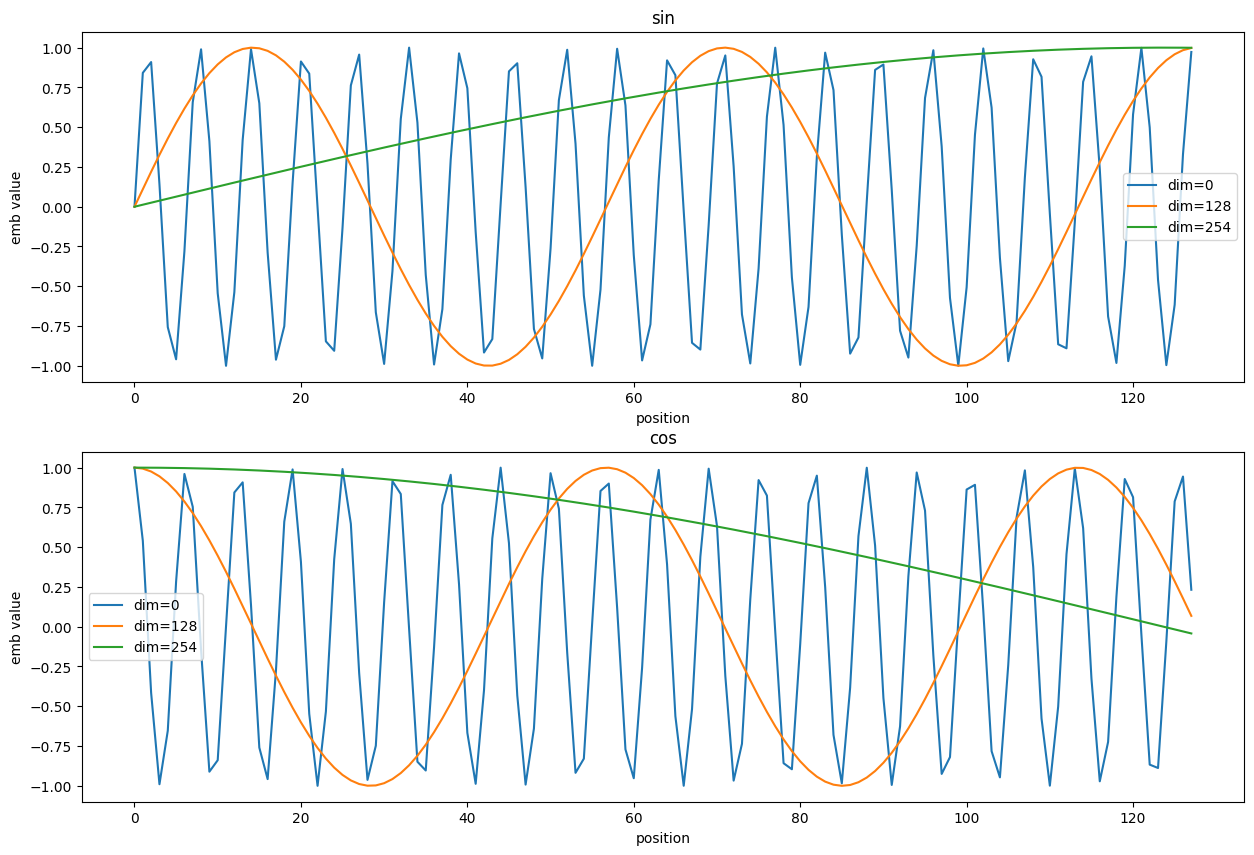

In [4]:
pos_enc = ddpm.PosEnc(max_pos=128, emb_dim=256, cycle_frac=0.25)

fig, ax = plt.subplots(figsize=(15, 10))
ax.imshow(pos_enc.pos_enc, cmap="bone")
ax.set_ylabel("position")
ax.set_xlabel("emb_dim")
plt.show()

fig, (sin_ax, cos_ax) = plt.subplots(nrows=2, figsize=(15, 10))
for i in [0, 128, 254]:
    sin_ax.plot(pos_enc.pos_enc[:, i], label=f"dim={i}")
    cos_ax.plot(pos_enc.pos_enc[:, i+1], label=f"dim={i}")

sin_ax.set_title("sin")
sin_ax.set_xlabel("position")
sin_ax.set_ylabel("emb value")
sin_ax.legend(loc=0)

cos_ax.set_title("cos")
cos_ax.set_xlabel("position")
cos_ax.set_ylabel("emb value")
cos_ax.legend(loc=0)

plt.show()

### BatchNorm vs GroupNorm
Diffusion models use GroupNorm and not BatchNorm. Why?

BatchNorm normalizes each channel dimension.

A channel is the output of a conv filter applied to an image. So you could imagine if you had 2 channels (feature maps), one from a vertical edge conv filter and another from a horizontal edge conv filter, normalizing over the channel dimension would mean making each feature map zero mean and unit variance, and then scaling and biasing.

For a conv feature map of shape (B, C, H, W), means and variances are calculated over (B, H, W). So if BatchNorm was applied to a batch of RGB images, BatchNorm would calculate a mean and variance for each color channel, and each color channel would be independently normalized. The insane and evil thing about BatchNorm is that **a normalized sample depends on all other samples in the batch**.

In diffusion training, the model is given images at various stages of the forward diffusion process, and must predict the added noise. So images in single a batch will have wildly different levels of noise. A BatchNorm inside a diffusion model would be calculating the feature map mean and variance over very clean images and very noisy ones, which doesn't make much sense, since why should the feature map distribution for clean and noisy images be the same?

GroupNorm normalizes each groups of channels, seperately for each batch. This removes the evil BatchNorm dependence across all samples in the batch.

GroupNorm with $|G| = C$ is InstanceNorm, and GroupNorm with $|G| = 1$ is LayerNorm.

## Sources
* Lil'Log Diffusion: https://lilianweng.github.io/posts/2021-07-11-diffusion-models/

* HuggingFace Annotated Diffusion: https://huggingface.co/blog/annotated-diffusion
* lucidrains implementation: https://github.com/lucidrains/denoising-diffusion-pytorch
* cloneofsimo implementation: https://github.com/cloneofsimo/minDiffusion

* DDPM paper: https://arxiv.org/pdf/2006.11239
* UNet paper: https://arxiv.org/pdf/1505.04597